# Static Hand Gesture UI Control

**Course Project:** Computer Vision Applications  
**Goal:** Control PC volume and media playback using real-time static hand gestures.

## Project Overview
This project implements a touchless interface using a standard webcam. It detects hand landmarks using **MediaPipe Hands**, extracts a 63-dimensional feature vector (21 points × x,y,z), and classifies the pose using a **Support Vector Machine (SVM)**. The recognized gestures are then mapped to system actions (Volume Up/Down, Mute, Play/Pause) via Python automation libraries.

### Workflow
1.  **Data Collection:** Capture labeled landmark samples for 5 gestures (Stop, Fist, Victory, Like, OK).
2.  **Model Training:** Train a lightweight SVM classifier on the collected dataset.
3.  **Real-Time Demo:** Run a live inference loop to control the PC.

## Setup Instructions
1.  **Create Environment:**
    ```powershell
    python -m venv .venv
    .\.venv\Scripts\Activate.ps1
    ```
2.  **Install Dependencies:**
    ```powershell
    pip install -r requirements.txt
    ```
3.  **Run Notebook:** Execute the cells below in order.

In [14]:
import sys
print(sys.executable)
print(sys.version)

c:\Users\Madi\Documents\season_25-26\academic_25-26\EE4211\compvision_proj\gesture-recog\.venv\Scripts\python.exe
3.10.11 (tags/v3.10.11:7d4cc5a, Apr  5 2023, 00:38:17) [MSC v.1929 64 bit (AMD64)]


## Data Collection

This module captures landmark coordinate samples for training the SVM classifier. The system records 63-dimensional feature vectors (21 MediaPipe hand landmarks × x,y,z coordinates) for four static gesture classes:

| Class | Gesture | Description |
|-------|---------|-------------|
| 0 | Stop | Open palm, all fingers extended |
| 1 | Fist | Closed hand |
| 2 | Like | Thumbs up |
| 3 | Thumbs Down | Thumb pointing downward |

**Navigation gestures** (Next/Previous track) are implemented via zone-based detection and do not require training data.

### Data Collection Protocol

**Note:** A pre-collected `gesture_data.csv` file is included in the repository for demonstration purposes. You can proceed directly to the training phase using this dataset. If you wish to collect fresh samples or customize the gestures, simply delete the existing CSV file and execute the cell below to record new data.

1. **Environment Setup:**
   - Activate virtual environment: `.\.venv\Scripts\Activate.ps1`
   - Verify dependencies installed: `pip list`
   - Ensure adequate lighting and camera functionality

2. **Recording Procedure:**
   - Execute the cell below to launch the collection interface
   - Press numeric keys `0`–`3` to begin recording each gesture class
   - Hold each pose for 3–5 seconds while moving slightly to capture variance
   - Press `SPACE` to pause between gesture transitions
   - Target: **≥200 samples per class** (800 total minimum)

3. **Data Augmentation:**
   - Vary hand distance from camera (0.5m – 1.5m)
   - Include slight rotations (±15°)
   - Capture under different lighting conditions
   - Use both left and right hands

4. **Output:**
   - Press `q` to terminate and save
   - Dataset saved to `gesture_data.csv` in project root
   - Console displays per-class sample counts and validation status

In [15]:
import cv2
import mediapipe as mp
import numpy as np
import csv
from collections import Counter

mp_hands = mp.solutions.hands
# Updated to support 2 hands
hands = mp_hands.Hands(static_image_mode=False, max_num_hands=2, min_detection_confidence=0.7)
mp_drawing = mp.solutions.drawing_utils

# Updated gesture list: Removed Victory/Rock, kept others
gesture_names = ["Stop", "Fist", "Like", "Thumbs Down"]
data = []
sample_counts = Counter()  # Track samples per gesture

cap = cv2.VideoCapture(0)
current_gesture = -1

# Make window visible and position it
window_name = 'Data Collection – Press 0–3 to record, q to quit'
cv2.namedWindow(window_name, cv2.WINDOW_NORMAL)
cv2.resizeWindow(window_name, 800, 600)
cv2.moveWindow(window_name, 100, 100)  # Position at top-left

print("=" * 60)
print("DATA COLLECTION STARTED (Dual Hand Support)")
print("=" * 60)
print("Instructions:")
print("  - Press 0-3 to start recording that gesture")
print("  - Press SPACE to PAUSE recording (use this to switch gestures!)")
print("  - Hold the pose for a few seconds (aim for ~200+ samples per gesture)")
print("  - You can use ONE or BOTH hands. Each detected hand counts as a sample.")
print("  - Press 'q' in the video window to quit and save")
print("=" * 60)
print("\nWaiting for gesture selection...")

frame_count = 0
last_print_count = 0

while cap.isOpened():
    ret, frame = cap.read()
    if not ret:
        print("ERROR: Could not read from camera. Check camera permissions.")
        break
    
    frame = cv2.flip(frame, 1)  # mirror
    rgb_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    results = hands.process(rgb_frame)

    # Count samples per gesture for display
    if data:
        sample_counts = Counter([row[-1] for row in data])
    
    # Draw on frame
    if results.multi_hand_landmarks:
        for hand_landmarks in results.multi_hand_landmarks:
            mp_drawing.draw_landmarks(frame, hand_landmarks, mp_hands.HAND_CONNECTIONS)

            # Extract & save when recording
            if 0 <= current_gesture < len(gesture_names):
                landmarks = []
                for lm in hand_landmarks.landmark:
                    landmarks.extend([lm.x, lm.y, lm.z])
                landmarks.append(current_gesture)  # label at the end
                data.append(landmarks)
        
        # Show current gesture name and sample count
        if 0 <= current_gesture < len(gesture_names):
            count = sample_counts.get(current_gesture, 0)
            text = f"Recording: {gesture_names[current_gesture]} ({count} samples)"
            cv2.putText(frame, text, (10, 60),
                        cv2.FONT_HERSHEY_SIMPLEX, 1.0, (0, 255, 0), 3)
        else:
            cv2.putText(frame, "PAUSED: Press 0-3 to record", (10, 60),
                        cv2.FONT_HERSHEY_SIMPLEX, 0.8, (0, 255, 255), 2)
    else:
        # No hand detected
        if current_gesture >= 0:
            cv2.putText(frame, f"Recording: {gesture_names[current_gesture]} (no hand detected)", 
                       (10, 60), cv2.FONT_HERSHEY_SIMPLEX, 0.8, (0, 0, 255), 2)
    
    # Show sample counts for all gestures
    y_offset = 100
    cv2.putText(frame, "Sample counts:", (10, y_offset),
                cv2.FONT_HERSHEY_SIMPLEX, 0.6, (255, 255, 255), 2)
    for i, name in enumerate(gesture_names):
        count = sample_counts.get(i, 0)
        color = (0, 255, 0) if count >= 200 else (0, 165, 255) if count >= 100 else (0, 0, 255)
        cv2.putText(frame, f"  {i}: {name} = {count}", (10, y_offset + 30 + i * 25),
                    cv2.FONT_HERSHEY_SIMPLEX, 0.6, color, 2)
    
    # Show total
    total = len(data)
    cv2.putText(frame, f"TOTAL: {total} samples", (10, y_offset + 180),
                cv2.FONT_HERSHEY_SIMPLEX, 0.7, (255, 255, 0), 2)

    cv2.imshow(window_name, frame)

    # Print progress every 50 samples
    if len(data) - last_print_count >= 50:
        print(f"\nProgress: {len(data)} total samples collected")
        for i, name in enumerate(gesture_names):
            count = sample_counts.get(i, 0)
            print(f"  {i}: {name} = {count} samples")
        last_print_count = len(data)

    key = cv2.waitKey(1) & 0xFF
    if key == ord('q'):
        print("\nQuitting...")
        break
    elif key == ord(' '):
        current_gesture = -1
        print("\n>>> PAUSED recording. Switch your hand pose, then press 0-3 to resume.")
    elif key in [ord('0'), ord('1'), ord('2'), ord('3')]:
        current_gesture = int(chr(key))
        print(f"\n>>> Now recording: {gesture_names[current_gesture]}")

cap.release()
cv2.destroyAllWindows()

# Save
if data:
    with open('gesture_data.csv', 'w', newline='') as f:
        writer = csv.writer(f)
        writer.writerow([f'x{i}' for i in range(63)] + ['label'])
        writer.writerows(data)
    
    print("\n" + "=" * 60)
    print(f"SUCCESS! Saved {len(data)} samples to gesture_data.csv")
    print("=" * 60)
    print("Sample breakdown:")
    final_counts = Counter([row[-1] for row in data])
    for i, name in enumerate(gesture_names):
        count = final_counts.get(i, 0)
        status = "✓" if count >= 200 else "⚠" if count >= 100 else "✗"
        print(f"  {status} {i}: {name} = {count} samples")
    print("=" * 60)
else:
    print("\nWARNING: No data collected! Make sure to press 0-3 to start recording.")

DATA COLLECTION STARTED (Dual Hand Support)
Instructions:
  - Press 0-3 to start recording that gesture
  - Press SPACE to PAUSE recording (use this to switch gestures!)
  - Hold the pose for a few seconds (aim for ~200+ samples per gesture)
  - You can use ONE or BOTH hands. Each detected hand counts as a sample.
  - Press 'q' in the video window to quit and save

Waiting for gesture selection...

>>> Now recording: Stop

>>> Now recording: Stop

Progress: 51 total samples collected
  0: Stop = 49 samples
  1: Fist = 0 samples
  2: Like = 0 samples
  3: Thumbs Down = 0 samples

Progress: 51 total samples collected
  0: Stop = 49 samples
  1: Fist = 0 samples
  2: Like = 0 samples
  3: Thumbs Down = 0 samples

Progress: 101 total samples collected
  0: Stop = 99 samples
  1: Fist = 0 samples
  2: Like = 0 samples
  3: Thumbs Down = 0 samples

Progress: 101 total samples collected
  0: Stop = 99 samples
  1: Fist = 0 samples
  2: Like = 0 samples
  3: Thumbs Down = 0 samples

Progress: 

## Model Training & Evaluation

This module trains a Support Vector Machine (SVM) classifier on the collected landmark dataset and evaluates its performance using standard machine learning metrics.

### Pipeline Architecture

**Preprocessing:**
- `StandardScaler`: Normalizes feature vectors to zero mean and unit variance
- Applied to all 63 dimensions (21 landmarks × 3 coordinates)

**Classifier Configuration:**
- **Algorithm:** Support Vector Machine (SVM)
- **Kernel:** Radial Basis Function (RBF)
- **Regularization:** C=10
- **Gamma:** Auto-scaled based on feature variance
- **Probability Estimates:** Enabled for confidence scoring

### Training Procedure

1. Load `gesture_data.csv` from project root
2. Split dataset: 80% training, 20% testing (stratified by class)
3. Fit preprocessing + SVM pipeline on training set
4. Generate performance metrics on test set
5. Serialize trained model to `gesture_classifier.pkl`

### Evaluation Metrics

- **Overall Accuracy:** Classification rate on test set
- **Per-Class Precision/Recall/F1:** Breakdown by gesture
- **Confusion Matrix:** Heatmap visualization of prediction patterns

**Prerequisites:** Ensure `gesture_data.csv` exists in project root with ≥800 samples before executing.

Test accuracy: 1.0000

Classification report:

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       189
           1       1.00      1.00      1.00       188
           2       1.00      1.00      1.00       190
           3       1.00      1.00      1.00       189

    accuracy                           1.00       756
   macro avg       1.00      1.00      1.00       756
weighted avg       1.00      1.00      1.00       756



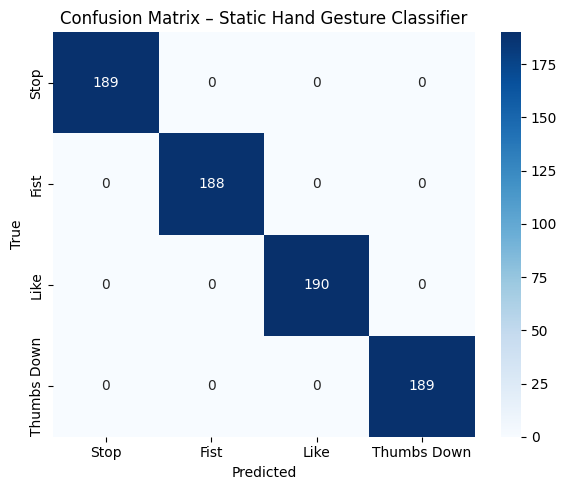

Saved model to gesture_classifier.pkl


In [16]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix
import joblib
import seaborn as sns
import matplotlib.pyplot as plt

# Load data
df = pd.read_csv('gesture_data.csv')
X = df.iloc[:, :-1].values
y = df['label'].values

# Train/test split (stratified)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# SVM pipeline
clf = make_pipeline(
    StandardScaler(),
    SVC(kernel='rbf', C=10, gamma='scale', probability=True)
)
clf.fit(X_train, y_train)

# Evaluation
accuracy = clf.score(X_test, y_test)
print(f"Test accuracy: {accuracy:.4f}")

y_pred = clf.predict(X_test)
print("\nClassification report:\n")
print(classification_report(y_test, y_pred))

# Confusion matrix
gesture_labels = ["Stop", "Fist", "Like", "Thumbs Down"]
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=gesture_labels,
            yticklabels=gesture_labels)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix – Static Hand Gesture Classifier')
plt.tight_layout()
plt.show()

# Save model
joblib.dump(clf, 'gesture_classifier.pkl')
print("Saved model to gesture_classifier.pkl")

## Real-Time Inference & System Control

This module implements a hybrid gesture recognition system combining **static pose classification** with **zone-based navigation** for media control.

### System Architecture

**Static Gesture Recognition:**
- SVM classifier with RBF kernel processes 63D landmark features
- Confidence threshold: **p ≥ 0.88**
- Stability requirement: **3 consecutive frames**
- Debounce interval: **1.1 seconds**

**Zone-Based Navigation:**
- Screen partitioned into three horizontal zones: LEFT (0–25%), CENTER (25–75%), RIGHT (75–100%)
- Transitions from CENTER → edge zones trigger media navigation
- Cooldown: **1.5 seconds** between swipe actions

### Gesture Mapping

| Mode | Gesture | System Action |
|------|---------|---------------|
| Static (CENTER) | Stop (open palm) | Media play/pause toggle |
| Static (CENTER) | Fist | Audio mute toggle |
| Static (CENTER) | Like (thumbs up) | Volume +10% |
| Static (CENTER) | Thumbs Down | Volume −10% |
| Navigation | CENTER → LEFT zone | Previous track |
| Navigation | CENTER → RIGHT zone | Next track |

### Execution Requirements

- **Platform:** Native Windows (WSL not supported due to `pycaw` dependency)
- **Model:** `gesture_classifier.pkl` from training phase
- **Hardware:** Functional webcam, audio output device
- **Permissions:** Camera access, system audio control

### Usage Notes

- Static gestures only trigger in CENTER zone
- Use two-hand strategy: one for navigation, one for static controls
- Visual feedback: zone indicators, confidence meters, action confirmations
- Press `q` to terminate

In [ ]:
import cv2
import mediapipe as mp
import numpy as np
import joblib
import pyautogui
from pycaw.pycaw import AudioUtilities, IAudioEndpointVolume
from comtypes import CLSCTX_ALL
from ctypes import cast, POINTER
import time

# Gesture names must match training order
gesture_names = ["Stop", "Fist", "Like", "Thumbs Down"]

# Load trained classifier
clf = joblib.load('gesture_classifier.pkl')

# Setup MediaPipe Hands
mp_hands = mp.solutions.hands
hands = mp_hands.Hands(static_image_mode=False, max_num_hands=2, min_detection_confidence=0.7)
mp_drawing = mp.solutions.drawing_utils

# Setup system volume control (pycaw)
try:
    devices = AudioUtilities.GetSpeakers()
    interface = devices.Activate(IAudioEndpointVolume._iid_, CLSCTX_ALL, None)
    volume = cast(interface, POINTER(IAudioEndpointVolume))
    print("Volume control initialized successfully.")
except Exception as e:
    print(f"Warning: Could not initialize volume control: {e}")
    volume = None

# Static gesture state - INCREASED THRESHOLDS
confidence_threshold = 0.88  # Higher confidence required
cooldown_seconds = 1.1  # Longer cooldown
last_gesture = -1
last_trigger_time = 0.0
stable_count = 0
stable_threshold = 3  # Need 3 consecutive frames

# ZONE-BASED SWIPE - WIDER CENTER ZONE
swipe_state = "CENTER"
swipe_last_action = 0.0
swipe_cooldown = 1.5  # Longer cooldown for swipes
zone_left = 0.25  # Wider center: only left 25% is LEFT zone
zone_right = 0.75  # Only right 25% is RIGHT zone (center is 50% wide)

print(f"Confidence threshold: {confidence_threshold}")
print("\n=== ZONE-BASED NAVIGATION (Enhanced) ===")
print("Screen zones: LEFT (0-25%) | CENTER (25-75%) | RIGHT (75-100%)")
print("")
print("NAVIGATION:")
print("  - Keep hand in CENTER zone for static gestures")
print("  - Move to LEFT edge → Previous track")
print("  - Move to RIGHT edge → Next track")
print("  - Return to CENTER before next swipe")
print("")
print("STATIC GESTURES (use in CENTER):")
print("  Stop (palm) = Play/Pause")
print("  Fist = Mute")
print("  Like (thumbs up) = Vol+")
print("  Thumbs Down = Vol-")
print("")
print("TIPS FOR ROBUST CONTROL:")
print("  1. Use ONE hand for swipes, OTHER hand for static gestures")
print("  2. When swiping, make a FIST to avoid triggering static gestures")
print("  3. Hold static gestures steady for ~1 second in CENTER zone")
print("  4. Keep hand at chest height, well-lit, and clearly visible")
print("=======================================\n")

cap = cv2.VideoCapture(0)
window_name = 'Gesture Control – Press q to quit'
cv2.namedWindow(window_name, cv2.WINDOW_NORMAL)
cv2.resizeWindow(window_name, 1600, 900)

print("Starting gesture control. Press 'q' to quit.")

while cap.isOpened():
    ret, frame = cap.read()
    if not ret:
        break

    frame = cv2.flip(frame, 1)
    h, w, _ = frame.shape
    
    # Draw zone dividers with WIDER center
    left_x = int(w * zone_left)
    right_x = int(w * zone_right)
    cv2.line(frame, (left_x, 0), (left_x, h), (150, 150, 150), 3)
    cv2.line(frame, (right_x, 0), (right_x, h), (150, 150, 150), 3)
    
    # Zone labels
    cv2.putText(frame, "LEFT", (50, 50), cv2.FONT_HERSHEY_SIMPLEX, 0.8, (150, 150, 150), 2)
    cv2.putText(frame, "CENTER (Static Gestures)", (left_x + 80, 50), 
                cv2.FONT_HERSHEY_SIMPLEX, 0.8, (150, 150, 150), 2)
    cv2.putText(frame, "RIGHT", (right_x + 50, 50), cv2.FONT_HERSHEY_SIMPLEX, 0.8, (150, 150, 150), 2)
    
    rgb_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    results = hands.process(rgb_frame)
    now = time.time()

    if results.multi_hand_landmarks:
        for hand_landmarks in results.multi_hand_landmarks:
            mp_drawing.draw_landmarks(frame, hand_landmarks, mp_hands.HAND_CONNECTIONS)

            wrist = hand_landmarks.landmark[0]
            wrist_x = wrist.x
            
            # --- ZONE-BASED SWIPE ---
            new_state = swipe_state
            if wrist_x < zone_left:
                new_state = "LEFT"
            elif wrist_x > zone_right:
                new_state = "RIGHT"
            else:
                new_state = "CENTER"
            
            # Trigger on zone transition FROM CENTER
            if now - swipe_last_action > swipe_cooldown:
                if swipe_state == "CENTER" and new_state == "LEFT":
                    pyautogui.press('prevtrack')
                    print("<<< LEFT ZONE → Previous Track")
                    cv2.putText(frame, "<<< PREVIOUS", (50, 200), 
                               cv2.FONT_HERSHEY_SIMPLEX, 2.5, (0, 255, 255), 5)
                    swipe_last_action = now
                    stable_count = 0  # Reset static gesture counter
                elif swipe_state == "CENTER" and new_state == "RIGHT":
                    pyautogui.press('nexttrack')
                    print(">>> RIGHT ZONE → Next Track")
                    cv2.putText(frame, "NEXT >>>", (w - 450, 200), 
                               cv2.FONT_HERSHEY_SIMPLEX, 2.5, (0, 255, 255), 5)
                    swipe_last_action = now
                    stable_count = 0  # Reset static gesture counter
            
            swipe_state = new_state
            
            # Show current zone with emphasis
            zone_text = f"Zone: {swipe_state}"
            if swipe_state == "CENTER":
                zone_color = (0, 255, 0)  # Green for center
                zone_bg_color = (0, 80, 0)
            else:
                zone_color = (255, 150, 0)  # Orange for edges
                zone_bg_color = (80, 50, 0)
            
            # Background for zone text
            cv2.rectangle(frame, (40, 80), (280, 130), zone_bg_color, -1)
            cv2.putText(frame, zone_text, (50, 120), 
                       cv2.FONT_HERSHEY_SIMPLEX, 1.2, zone_color, 3)

            # --- STATIC GESTURE RECOGNITION (ONLY IN CENTER ZONE) ---
            if swipe_state != "CENTER":
                stable_count = 0
                cv2.putText(frame, "Static gestures disabled in edge zones", (50, 680), 
                           cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 165, 255), 2)
                continue
            
            # Check if recently swiped
            if now - swipe_last_action < 0.6:
                stable_count = 0
                continue
            
            xs = [lm.x for lm in hand_landmarks.landmark]
            ys = [lm.y for lm in hand_landmarks.landmark]
            bbox_area = (max(xs) - min(xs)) * (max(ys) - min(ys))
            
            if bbox_area < 0.008:
                stable_count = 0
                continue

            landmarks = []
            for lm in hand_landmarks.landmark:
                landmarks.extend([lm.x, lm.y, lm.z])
            landmarks = np.array([landmarks])

            probs = clf.predict_proba(landmarks)[0]
            prediction = int(np.argmax(probs))
            confidence = float(np.max(probs))

            gesture_name = gesture_names[prediction] if prediction < len(gesture_names) else f"Class {prediction}"
            
            # Stability tracking
            if confidence >= confidence_threshold:
                if prediction == last_gesture or last_gesture == -1:
                    stable_count += 1
                else:
                    stable_count = 1
                    last_gesture = prediction
                    
                ready_to_trigger = (stable_count >= stable_threshold and 
                                   now - last_trigger_time >= cooldown_seconds)
                
                if ready_to_trigger:
                    color = (0, 255, 0)  # GREEN - ready
                    status = "[READY]"
                else:
                    color = (0, 165, 255)  # ORANGE - building stability
                    status = f"[{stable_count}/{stable_threshold}]"
            else:
                color = (0, 0, 255)  # RED - low confidence
                status = "[LOW CONF]"
                stable_count = 0

            # Display prediction with stability counter
            txt_x = max(10, min(w - 300, int(wrist_x * w)))
            txt_y = max(80, min(h - 50, int(wrist.y * h) - 40))
            label = f"{gesture_name} {status} ({confidence:.2f})"
            cv2.putText(frame, label, (txt_x, txt_y), 
                       cv2.FONT_HERSHEY_SIMPLEX, 0.9, color, 3, cv2.LINE_AA)

            # Execute action only when fully stable
            if confidence >= confidence_threshold and stable_count >= stable_threshold:
                if now - last_trigger_time >= cooldown_seconds:
                    if prediction == 0:  # Stop
                        pyautogui.press('playpause')
                        print(f"✓ {gesture_name} → Play/Pause")
                        cv2.putText(frame, "PLAY/PAUSE", (w//2 - 150, h//2), 
                                   cv2.FONT_HERSHEY_SIMPLEX, 2.0, (0, 255, 0), 4)
                    elif prediction == 1 and volume:  # Fist
                        muted = volume.GetMute()
                        volume.SetMute(not muted, None)
                        print(f"✓ {gesture_name} → Mute Toggle")
                        cv2.putText(frame, "MUTE", (w//2 - 80, h//2), 
                                   cv2.FONT_HERSHEY_SIMPLEX, 2.0, (255, 0, 0), 4)
                    elif prediction == 2 and volume:  # Like
                        current = volume.GetMasterVolumeLevelScalar()
                        volume.SetMasterVolumeLevelScalar(min(1.0, current + 0.1), None)
                        print(f"✓ {gesture_name} → Volume UP")
                        cv2.putText(frame, "VOL +", (w//2 - 80, h//2), 
                                   cv2.FONT_HERSHEY_SIMPLEX, 2.0, (0, 255, 0), 4)
                    elif prediction == 3 and volume:  # Thumbs Down
                        current = volume.GetMasterVolumeLevelScalar()
                        volume.SetMasterVolumeLevelScalar(max(0.0, current - 0.1), None)
                        print(f"✓ {gesture_name} → Volume DOWN")
                        cv2.putText(frame, "VOL -", (w//2 - 80, h//2), 
                                   cv2.FONT_HERSHEY_SIMPLEX, 2.0, (255, 165, 0), 4)
                    
                    last_gesture = prediction
                    last_trigger_time = now
                    stable_count = 0

    else:
        stable_count = 0
        swipe_state = "CENTER"

    cv2.imshow(window_name, frame)
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

cap.release()
cv2.destroyAllWindows()

Volume control initialized successfully.
Confidence threshold: 0.88

=== ZONE-BASED NAVIGATION (Enhanced) ===
Screen zones: LEFT (0-25%) | CENTER (25-75%) | RIGHT (75-100%)

NAVIGATION:
  - Keep hand in CENTER zone for static gestures
  - Move to LEFT edge → Previous track
  - Move to RIGHT edge → Next track
  - Return to CENTER before next swipe

STATIC GESTURES (use in CENTER):
  Stop (palm) = Play/Pause
  Fist = Mute
  Like (thumbs up) = Vol+
  Thumbs Down = Vol-

TIPS FOR ROBUST CONTROL:
  1. Use ONE hand for swipes, OTHER hand for static gestures
  2. When swiping, make a FIST to avoid triggering static gestures
  3. Hold static gestures steady for ~1 second in CENTER zone
  4. Keep hand at chest height, well-lit, and clearly visible

Starting gesture control. Press 'q' to quit.
Starting gesture control. Press 'q' to quit.
✓ Stop → Play/Pause
✓ Stop → Play/Pause
✓ Stop → Play/Pause
✓ Stop → Play/Pause
✓ Stop → Play/Pause
✓ Stop → Play/Pause
✓ Stop → Play/Pause
✓ Stop → Play/Pause
